In [331]:
import numpy
import csv
from sensor import *
import copy
import pandas as pd
import numpy as np
import time
import datetime
import math
from pylab import *
# グラフをインラインで表示させる
%matplotlib inline

In [2]:
ohyama = Ohyama()

In [3]:
F_MOUNTH = '07'
F_DAY = '01'
T_MOUNTH = '09'
T_DAY = '01'
f = '2016-' + F_MOUNTH + '-' + F_DAY + 'T00:00:00%2B00:00'
t = '2016-' +  T_MOUNTH + '-' + T_DAY + 'T00:00:00%2B00:00'

In [4]:
data = ohyama.sensor_list[0].get_data(From=f, To=False, interval='60000')

In [12]:
df = pd.DataFrame(data[1], columns=data[0])
df = df.drop(df[df['numerics.wind.direction'] == ''].index)
df.head()

time numerics.temperature.atmospheric  \
0  1.468645e+12                             20.1   
1  1.468646e+12                             19.9   
2  1.468646e+12                             19.9   
3  1.468647e+12                             19.9   
4  1.468647e+12                             19.7   

  numerics.humidity.atmospheric numerics.illumination.atmospheric  \
0                            98                            7896.8   
1                            99                            7613.3   
2                            98                            7405.4   
3                            98                            8797.7   
4                            98                            7972.4   

  numerics.rain.precipitation numerics.wind.direction numerics.wind.velocity  \
0                           0                     197                      0   
1                           0                     153                      0   
2                           0                     178                      0   
3                           0                     179                    0.1   
4                           0                     184                      0   

  numerics.wind.maxInstantaneousVelocity  numerics.pressure.atmospheric  
0                                      0                          932.0  
1                                      0                          932.0  
2                                    1.1                          932.0  
3                                    2.2                          932.0  
4                                    1.1                          932.0

In [6]:
def df2float(df):
    d = df.as_matrix().astype(np.float64)
    datetime_list = []
    for t in d.T[0]:
        datetime_list.append(pd.to_datetime(datetime.datetime(*time.localtime(float(t)/1000)[:6])))
    break_list = [1]
    diff_cos = [0.0]
    diff_cos = [0.0]
    for i in range(1,len(d.T[0])):
        if d.T[0][i] - d.T[0][i-1]  > 1000000.0:
            break_list.append(1)
        else:
            break_list.append(0)
    
    df_tmp = pd.DataFrame(d, columns=df.columns)
    df_tmp['detetime'] = datetime_list
    df_tmp['break'] = break_list
    
    return df_tmp

In [10]:
def v2sincos(df):
    df_tmp = df
    v_list = df[['numerics.wind.direction']].as_matrix().T[0]
    result = np.array([np.cos(np.deg2rad(v_list))])
    result = np.append(result, np.array([np.sin(np.deg2rad(v_list))]), axis=0)
    #print(result[0])
    df_tmp['wind_direction_cos'] = result[0]
    df_tmp['wind_direction_sin'] = result[1]
    return df_tmp

In [8]:
def calc_diff(df):
    diff_wind_direction = [0.0]
    matrix = df[['break', 'numerics.wind.direction']].as_matrix()
    for i in range(1,len(matrix)):
        if matrix[i][0] == 1:
            diff_wind_direction.append(0.0)
        else:
            if matrix[i][1] >= matrix[i-1][1]:
                if matrix[i][1] - matrix[i-1][1] <= 180:
                    diff_wind_direction.append(matrix[i][1] - matrix[i-1][1])
                else:
                    diff_wind_direction.append( -360.0 + matrix[i][1] - matrix[i-1][1])
            else:
                if matrix[i-1][1] - matrix[i][1] <= 180:
                    diff_wind_direction.append(- matrix[i-1][1] + matrix[i][1])
                else:
                    diff_wind_direction.append(360.0 - (matrix[i-1][1] - matrix[i][1]))
                    
    df_tmp = df
    df_tmp['diff_wind_direction'] = diff_wind_direction
    return df_tmp

In [13]:
df = df2float(df)
df = v2sincos(df)
df = calc_diff(df)

In [60]:
df.describe()

time  numerics.temperature.atmospheric  \
count  1.873200e+04                      18732.000000   
mean   1.476085e+12                         15.902472   
std    4.579210e+09                          7.417151   
min    1.468645e+12                        -14.400000   
25%    1.472024e+12                          9.800000   
50%    1.475878e+12                         17.800000   
75%    1.480128e+12                         21.900000   
max    1.484212e+12                         34.600000   

       numerics.humidity.atmospheric  numerics.illumination.atmospheric  \
count                   18732.000000                       18732.000000   
mean                       75.639921                       12082.634812   
std                        19.308101                       20891.764642   
min                        18.000000                           0.000000   
25%                        62.000000                           0.000000   
50%                        80.000000                        1250.900000   
75%                        92.000000                       13994.200000   
max                        99.000000                      116657.200000   

       numerics.rain.precipitation  numerics.wind.direction  \
count                 18732.000000             18732.000000   
mean                      0.059849               167.591661   
std                       0.429730                84.659771   
min                       0.000000                 0.000000   
25%                       0.000000               128.000000   
50%                       0.000000               176.000000   
75%                       0.000000               203.000000   
max                      18.600000               359.000000   

       numerics.wind.velocity  numerics.wind.maxInstantaneousVelocity  \
count            18732.000000                            18732.000000   
mean                 0.196397                                1.614681   
std                  0.296941                                1.441886   
min                  0.000000                                0.000000   
25%                  0.000000                                1.100000   
50%                  0.100000                                1.100000   
75%                  0.300000                                2.200000   
max                  4.100000                               22.300000   

       numerics.pressure.atmospheric         break  wind_direction_cos  \
count                   18732.000000  18732.000000        18732.000000   
mean                      936.653160      0.006193           -0.361587   
std                         6.092614      0.078451            0.764571   
min                       910.000000      0.000000           -1.000000   
25%                       933.000000      0.000000           -0.981627   
50%                       937.000000      0.000000           -0.829038   
75%                       941.000000      0.000000            0.374607   
max                       951.000000      1.000000            1.000000   

       wind_direction_sin  diff_wind_direction  
count        18732.000000         18732.000000  
mean             0.057019            -0.016015  
std              0.530549            44.750268  
min             -1.000000          -180.000000  
25%             -0.292372           -14.000000  
50%              0.052336             0.000000  
75%              0.438371            15.000000  
max              1.000000           180.000000

(array([ 4764.,  2198.,   836.,   489.,   518.,   671.,   274.,   187.,
          122.,    24.]),
 array([  7.80000000e+00,   1.16727400e+04,   2.33376800e+04,
          3.50026200e+04,   4.66675600e+04,   5.83325000e+04,
          6.99974400e+04,   8.16623800e+04,   9.33273200e+04,
          1.04992260e+05,   1.16657200e+05]),
 <a list of 10 Patch objects>)

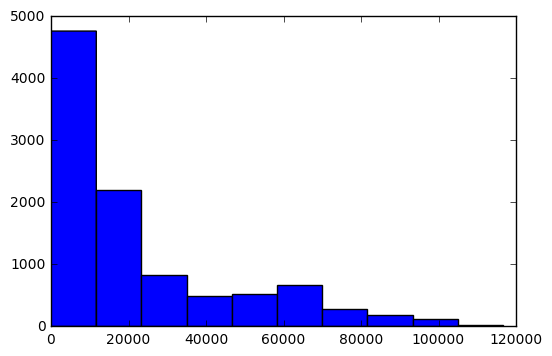

In [193]:
plt.hist(df[df['numerics.illumination.atmospheric'] > 0][['numerics.illumination.atmospheric']].as_matrix().T[0])

In [63]:
df_rain = df[df['numerics.rain.precipitation'] > 0]
df_sunny = df[df['numerics.rain.precipitation'] == 0]

In [65]:
rain_datetime = []
for dt in df_rain[['detetime']].as_matrix().T[0]:
    rain_datetime.append(datetime.datetime.utcfromtimestamp(dt.tolist()/1e9))

In [68]:
sunny_datetime = []
for dt in df_sunny[['detetime']].as_matrix().T[0]:
    sunny_datetime.append(datetime.datetime.utcfromtimestamp(dt.tolist()/1e9))

In [55]:
sr = []
rr = []
for i, r in enumerate(rain_datetime):
    s_time = r - datetime.timedelta(minutes = 21)
    bl = False
    if s_time < rain_datetime[i-2]:
        rr.append(r)
    else:
        sr.append(r)

In [69]:
rs = []
ss = []
for i, s in enumerate(sunny_datetime):
    s_time = s - datetime.timedelta(minutes = 21)
    bl = False
    if s_time < sunny_datetime[i-2]:
        ss.append(s)
    else:
        rs.append(s)

In [306]:
def check_rain(df):
    if len(df[['numerics.rain.precipitation']].as_matrix()) != 7:
        return -1
    if df[['numerics.rain.precipitation']].as_matrix()[-1][0] == 0.0:
        return 0
    else:
        return 1

In [255]:
def get_rain(df): # 雨の長さと周期: 2
    count = -1.0
    count_p = 0.0
    bo = True
    for r in reversed(list(df[['numerics.rain.precipitation']].as_matrix().T[0])):
        if r > 0:
            count += 1.0
            if bo == False:
                count_p += 1
                bo = False
        else:
            if bo == True:
                count_p += 1
                bo = True
        
    return [count/6.0 , count_p/6.0]

In [256]:
def get_hum(df): # 現在の湿度のデータを区分：　３
    hum = df[['numerics.humidity.atmospheric']].as_matrix().T[0][-1]
    result = [0.0, 0.0, 0.0]
    if hum < 80.0:
        result[0] = 1.0
    elif hum < 92.0:
        result[1] = 1.0
    else:
        result[2] = 1.0
    return result

In [257]:
def get_ill(df): # 現在の照度のデータを区分：　4
    ill = df[['numerics.illumination.atmospheric']].as_matrix().T[0][-1]
    result = [0.0, 0.0, 0.0, 0.0]
    if ill == 0.0:
        result[0] = 1.0
    elif ill < 1000:
        result[1] = 1.0
    elif ill < 15000:
        result[2] = 1.0
    else:
        result[3] = 1.0
    return result

In [359]:
def get_dir(df):# 風の向きのコサイン類似度　６
    rain_cos_sin = np.load('cluster_data/rain_cos_sin.npy')
    d_cs = df[['wind_direction_cos', 'wind_direction_sin']].as_matrix()[-1]
    min_len = 100.0
    max_i = 0
    for i,cs in enumerate(rain_cos_sin):
        if np.sqrt(np.power(d_cs - cs, 2).sum()) < min_len:
            min_len = np.sqrt(np.power(d_cs - cs, 2).sum())
            max_i = i
    
    
    result = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
    result[max_i] = 1.0
    return result

In [360]:
def get_diff(df): # 風の向きの変化量のコサイン類似度　６
    diff_wind_direction = np.load('cluster_data/diff_wind_direction.npy')
    d_diff = df[['diff_wind_direction']].as_matrix().T[0] / 180.0
    min_len = 100.0
    max_i = 0
    for i,diff in enumerate(diff_wind_direction):
        if np.sqrt(np.power(diff - d_diff, 2).sum()) < min_len:
            min_len = np.sqrt(np.power(diff - d_diff, 2).sum())
            max_i = i
            
    result = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
    result[max_i] = 1.0
    return result

In [361]:
def get_velm(df):
    velm_data = np.load('cluster_data/velm_wind.npy')
    velm = df[['numerics.wind.maxInstantaneousVelocity']].as_matrix().T[0]
    for i, vm in enumerate(velm):
        if vm < 1.1:
            velm[i] = 0.0
        elif vm < 2.2:
            velm[i] = 1.0
        else:
            velm[i] = 2.0
    
    min_len = 100.0
    max_i = 0
    for i,vm in enumerate(velm_data):
        if np.sqrt(np.power(velm - vm, 2).sum()) < min_len:
            min_len = np.sqrt(np.power(velm - vm, 2).sum())
            max_i = i
    
    result = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
    result[max_i] = 1.0
    return result

In [283]:
columns = ['now_sunny',
           'now_rain',
           'count_rain',
           'count_freq',
           'hum_80',
           'hum_80_92',
           'hum_92_',
           'ill_0',
           'ill_0_1000',
           'ill_1000_15000',
           'ill_15000_',
           'dir_1',
           'dir_2',
           'dir_3',
           'dir_4',
           'dir_5',
           'dir_6',
           'diff_1',
           'diff_2',
           'diff_3',
           'diff_4',
           'diff_5',
           'diff_6',
           'velm_1',
           'velm_2',
           'velm_3',
           'velm_4',
           'velm_5',
           'velm_6',
           'velm_7'
          ]

In [284]:
df_rr = pd.DataFrame([], columns=columns)
df_ss = pd.DataFrame([], columns=columns)
df_sr = pd.DataFrame([], columns=columns)
df_rs = pd.DataFrame([], columns=columns)

In [362]:
df_rr = pd.DataFrame([], columns=columns)
for d in rr:
    f = float(time.mktime(d.timetuple())) * 1000 - 60000 * 60 * 0.3
    s = f - 60000 * 60 * 1.1
    
    df_tmp = df[df['time'] > s]
    df_tmp = df_tmp[df_tmp['time'] <= f]
    
    if len(df_tmp[df_tmp['break'] > 0][['break']].as_matrix()) == 0:
        if check_rain(df_tmp) == 1:
            row = []
            row += [0.0, 1.0]        # 2 
            row += get_rain(df_tmp)  # 2
            row += get_hum(df_tmp)   # 3
            row += get_ill(df_tmp)   # 4
            row += get_dir(df_tmp)   # 6
            row += get_diff(df_tmp)  # 6
            row += get_velm(df_tmp)  # 7   total 30
            df2 = pd.DataFrame([row], columns=columns)
            df_rr = df_rr.append(df2)
df_rr.index = range(0, len(df_rr.as_matrix()))

In [363]:
df_rs = pd.DataFrame([], columns=columns)
for d in rs:
    f = float(time.mktime(d.timetuple())) * 1000 - 60000 * 60 * 0.3
    s = f - 60000 * 60 * 1.1
    
    df_tmp = df[df['time'] > s]
    df_tmp = df_tmp[df_tmp['time'] <= f]
    
    if len(df_tmp[df_tmp['break'] > 0][['break']].as_matrix()) == 0:
        if check_rain(df_tmp) == 1:
            row = []
            row += [0.0, 1.0]        # 2 
            row += get_rain(df_tmp)  # 2
            row += get_hum(df_tmp)   # 3
            row += get_ill(df_tmp)   # 4
            row += get_dir(df_tmp)   # 6
            row += get_diff(df_tmp)  # 6
            row += get_velm(df_tmp)  # 7   total 30
            df2 = pd.DataFrame([row], columns=columns)
            df_rs = df_rs.append(df2)
df_rs.index = range(0, len(df_rs.as_matrix()))

In [364]:
df_ss = pd.DataFrame([], columns=columns)
for d in ss:
    f = float(time.mktime(d.timetuple())) * 1000 - 60000 * 60 * 0.3
    s = f - 60000 * 60 * 1.1
    
    df_tmp = df[df['time'] > s]
    df_tmp = df_tmp[df_tmp['time'] <= f]
    
    if len(df_tmp[df_tmp['break'] > 0][['break']].as_matrix()) == 0:
        if check_rain(df_tmp) == 0:
            row = []
            row += [1.0, 0.0]        # 2 
            row += get_rain(df_tmp)  # 2
            row += get_hum(df_tmp)   # 3
            row += get_ill(df_tmp)   # 4
            row += get_dir(df_tmp)   # 6
            row += get_diff(df_tmp)  # 6
            row += get_velm(df_tmp)  # 7   total 30
            df2 = pd.DataFrame([row], columns=columns)
            df_ss = df_ss.append(df2)
df_ss.index = range(0, len(df_ss.as_matrix()))

In [365]:
df_sr = pd.DataFrame([], columns=columns)
for d in sr:
    f = float(time.mktime(d.timetuple())) * 1000 - 60000 * 60 * 0.3
    s = f - 60000 * 60 * 1.1
    
    df_tmp = df[df['time'] > s]
    df_tmp = df_tmp[df_tmp['time'] <= f]
    
    if len(df_tmp[df_tmp['break'] > 0][['break']].as_matrix()) == 0:
        if check_rain(df_tmp) == 0:
            row = []
            row += [1.0, 0.0]        # 2 
            row += get_rain(df_tmp)  # 2
            row += get_hum(df_tmp)   # 3
            row += get_ill(df_tmp)   # 4
            row += get_dir(df_tmp)   # 6
            row += get_diff(df_tmp)  # 6
            row += get_velm(df_tmp)  # 7   total 30
            df2 = pd.DataFrame([row], columns=columns)
            df_sr = df_sr.append(df2)
df_sr.index = range(0, len(df_sr.as_matrix()))

In [366]:
columns_tmp = columns[11:]

In [367]:
df_rr[columns_tmp].describe()

dir_1       dir_2       dir_3       dir_4       dir_5       dir_6  \
count  674.000000  674.000000  674.000000  674.000000  674.000000  674.000000   
mean     0.057864    0.097923    0.465875    0.050445    0.169139    0.158754   
std      0.233659    0.297431    0.499205    0.219024    0.375153    0.365718   
min      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
25%      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
50%      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
75%      0.000000    0.000000    1.000000    0.000000    0.000000    0.000000   
max      1.000000    1.000000    1.000000    1.000000    1.000000    1.000000   

           diff_1      diff_2      diff_3      diff_4      diff_5      diff_6  \
count  674.000000  674.000000  674.000000  674.000000  674.000000  674.000000   
mean     0.086053    0.523739    0.102374    0.183976    0.066766    0.037092   
std      0.280651    0.499807    0.303364    0.387753    0.249801    0.189128   
min      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
25%      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
50%      0.000000    1.000000    0.000000    0.000000    0.000000    0.000000   
75%      0.000000    1.000000    0.000000    0.000000    0.000000    0.000000   
max      1.000000    1.000000    1.000000    1.000000    1.000000    1.000000   

           velm_1      velm_2      velm_3      velm_4      velm_5      velm_6  \
count  674.000000  674.000000  674.000000  674.000000  674.000000  674.000000   
mean     0.155786    0.384273    0.097923    0.066766    0.117211    0.106825   
std      0.362922    0.486784    0.297431    0.249801    0.321910    0.309120   
min      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
25%      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
50%      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
75%      0.000000    1.000000    0.000000    0.000000    0.000000    0.000000   
max      1.000000    1.000000    1.000000    1.000000    1.000000    1.000000   

           velm_7  
count  674.000000  
mean     0.071217  
std      0.257377  
min      0.000000  
25%      0.000000  
50%      0.000000  
75%      0.000000  
max      1.000000

In [368]:
df_rs[columns_tmp].describe()

dir_1       dir_2       dir_3       dir_4       dir_5       dir_6  \
count  420.000000  420.000000  420.000000  420.000000  420.000000  420.000000   
mean     0.069048    0.097619    0.526190    0.064286    0.114286    0.128571   
std      0.253837    0.297153    0.499909    0.245554    0.318537    0.335124   
min      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
25%      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
50%      0.000000    0.000000    1.000000    0.000000    0.000000    0.000000   
75%      0.000000    0.000000    1.000000    0.000000    0.000000    0.000000   
max      1.000000    1.000000    1.000000    1.000000    1.000000    1.000000   

           diff_1      diff_2      diff_3      diff_4      diff_5      diff_6  \
count  420.000000  420.000000  420.000000  420.000000  420.000000  420.000000   
mean     0.107143    0.492857    0.102381    0.202381    0.054762    0.040476   
std      0.309664    0.500545    0.303510    0.402254    0.227786    0.197308   
min      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
25%      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
50%      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
75%      0.000000    1.000000    0.000000    0.000000    0.000000    0.000000   
max      1.000000    1.000000    1.000000    1.000000    1.000000    1.000000   

           velm_1      velm_2      velm_3      velm_4      velm_5      velm_6  \
count  420.000000  420.000000  420.000000  420.000000  420.000000  420.000000   
mean     0.178571    0.345238    0.083333    0.052381    0.111905    0.128571   
std      0.383450    0.476013    0.276715    0.223060    0.315625    0.335124   
min      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
25%      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
50%      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
75%      0.000000    1.000000    0.000000    0.000000    0.000000    0.000000   
max      1.000000    1.000000    1.000000    1.000000    1.000000    1.000000   

           velm_7  
count  420.000000  
mean     0.100000  
std      0.300358  
min      0.000000  
25%      0.000000  
50%      0.000000  
75%      0.000000  
max      1.000000

In [369]:
df_sr[columns_tmp].describe()

dir_1       dir_2       dir_3       dir_4       dir_5       dir_6  \
count  425.000000  425.000000  425.000000  425.000000  425.000000  425.000000   
mean     0.054118    0.101176    0.529412    0.051765    0.127059    0.136471   
std      0.226516    0.301918    0.499722    0.221813    0.333431    0.343692   
min      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
25%      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
50%      0.000000    0.000000    1.000000    0.000000    0.000000    0.000000   
75%      0.000000    0.000000    1.000000    0.000000    0.000000    0.000000   
max      1.000000    1.000000    1.000000    1.000000    1.000000    1.000000   

           diff_1      diff_2      diff_3      diff_4      diff_5      diff_6  \
count  425.000000  425.000000  425.000000  425.000000  425.000000  425.000000   
mean     0.108235    0.552941    0.103529    0.176471    0.030588    0.028235   
std      0.311043    0.497775    0.305008    0.381669    0.172402    0.165840   
min      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
25%      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
50%      0.000000    1.000000    0.000000    0.000000    0.000000    0.000000   
75%      0.000000    1.000000    0.000000    0.000000    0.000000    0.000000   
max      1.000000    1.000000    1.000000    1.000000    1.000000    1.000000   

           velm_1      velm_2      velm_3     velm_4      velm_5      velm_6  \
count  425.000000  425.000000  425.000000  425.00000  425.000000  425.000000   
mean     0.178824    0.345882    0.103529    0.04000    0.122353    0.112941   
std      0.383656    0.476216    0.305008    0.19619    0.328079    0.316894   
min      0.000000    0.000000    0.000000    0.00000    0.000000    0.000000   
25%      0.000000    0.000000    0.000000    0.00000    0.000000    0.000000   
50%      0.000000    0.000000    0.000000    0.00000    0.000000    0.000000   
75%      0.000000    1.000000    0.000000    0.00000    0.000000    0.000000   
max      1.000000    1.000000    1.000000    1.00000    1.000000    1.000000   

           velm_7  
count  425.000000  
mean     0.096471  
std      0.295583  
min      0.000000  
25%      0.000000  
50%      0.000000  
75%      0.000000  
max      1.000000

In [370]:
df_ss[columns_tmp].describe()

dir_1         dir_2         dir_3         dir_4         dir_5  \
count  15874.000000  15874.000000  15874.000000  15874.000000  15874.000000   
mean       0.047562      0.084730      0.516190      0.071312      0.133174   
std        0.212844      0.278488      0.499754      0.257353      0.339773   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.000000      0.000000      0.000000      0.000000      0.000000   
50%        0.000000      0.000000      1.000000      0.000000      0.000000   
75%        0.000000      0.000000      1.000000      0.000000      0.000000   
max        1.000000      1.000000      1.000000      1.000000      1.000000   

              dir_6        diff_1        diff_2        diff_3        diff_4  \
count  15874.000000  15874.000000  15874.000000  15874.000000  15874.000000   
mean       0.147033      0.076792      0.634182      0.080446      0.149490   
std        0.354150      0.266270      0.481674      0.271991      0.356582   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.000000      0.000000      0.000000      0.000000      0.000000   
50%        0.000000      0.000000      1.000000      0.000000      0.000000   
75%        0.000000      0.000000      1.000000      0.000000      0.000000   
max        1.000000      1.000000      1.000000      1.000000      1.000000   

             diff_5        diff_6        velm_1       velm_2        velm_3  \
count  15874.000000  15874.000000  15874.000000  15874.00000  15874.000000   
mean       0.034396      0.024694      0.220234      0.24537      0.132355   
std        0.182250      0.155197      0.414418      0.43032      0.338887   
min        0.000000      0.000000      0.000000      0.00000      0.000000   
25%        0.000000      0.000000      0.000000      0.00000      0.000000   
50%        0.000000      0.000000      0.000000      0.00000      0.000000   
75%        0.000000      0.000000      0.000000      0.00000      0.000000   
max        1.000000      1.000000      1.000000      1.00000      1.000000   

             velm_4        velm_5        velm_6        velm_7  
count  15874.000000  15874.000000  15874.000000  15874.000000  
mean       0.067154      0.115094      0.111503      0.108290  
std        0.250296      0.319145      0.314764      0.310756  
min        0.000000      0.000000      0.000000      0.000000  
25%        0.000000      0.000000      0.000000      0.000000  
50%        0.000000      0.000000      0.000000      0.000000  
75%        0.000000      0.000000      0.000000      0.000000  
max        1.000000      1.000000      1.000000      1.000000

In [371]:
df_rr.to_csv('train_data/rr.csv', index=None)
df_rs.to_csv('train_data/rs.csv', index=None)
df_sr.to_csv('train_data/sr.csv', index=None)
df_ss.to_csv('train_data/ss.csv', index=None)